# Use compare function results
- This is a 💥 idea. Thank you once again @anandthakker!

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [20]:
from sklearn import preprocessing
from sklearn.svm import SVC
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import learning_curve

/Users/bkowshik/anaconda/lib/python3.5/site-packages/sklearn/learning_curve.py:23: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [4]:
changesets = pd.read_csv('../data/use-compare-function-results/changesets.csv')
print(changesets.shape)
changesets.sample(2)

(64248, 19)


,ID,user,editor,Powerfull Editor,comment,source,imagery used,date,reasons,reasons__name,create,modify,delete,bbox,is suspect,harmful,checked,check_user__username,check date
62639,37207529,Silent7,JOSM/1.5 (9329 ru),True,леса; молодые леса,Bing,Not reported,2016-02-14T16:52:00+00:00,2.0,possible import,306.0,0.0,0.0,"SRID=4326;POLYGON ((54.9652697 58.3497383, 54....",True,False,True,andygol,2016-04-07T12:29:22.344002+00:00
45473,43193824,flockfinder,Go Map!! 1.4,False,Added tags,Not reported,Not reported,2016-10-26T14:15:29+00:00,13.0,edited a name tag,6.0,5.0,61.0,"SRID=4326;POLYGON ((-118.1686082 34.7231313, -...",True,False,True,dannykath,2016-11-29T15:55:20.227959+00:00


## Some numbers on "reasons"

In [5]:
# How many changesets have atleast one reason?
reason_changesets = changesets[changesets['reasons__name'].isnull() == False].drop_duplicates('ID')
print('Changests with atleast one reason: {}'.format(reason_changesets.shape[0]))

Changests with atleast one reason: 26990


In [6]:
# How many changesets have no reasons?
no_reason_changesets = changesets[changesets['reasons__name'].isnull()].drop_duplicates('ID')
print('Changests without a reason: {}'.format(no_reason_changesets.shape[0]))

Changests without a reason: 32257


In [7]:
reasons = changesets['reasons__name'].dropna().drop_duplicates().values
print(reasons)
print('Number of reasons: {}'.format(len(reasons)))

['Major name modification' 'New mapper' 'suspect_word'
 'Added invalid highway tag' 'possible import' 'Invalid tag modification'
 'Edited a place' 'mass deletion' 'Flagged by gabbar'
 'Edited an osm landmark' 'Edited a major lake' 'mass modification'
 'New footway created' 'Invalid key value combination'
 'Edited a major road' 'Unknown iD instance' 'Feature with Pokename'
 'Added a large building' 'Edited an old monument'
 'Added a new place(city/town/country)' 'Deleted a wikidata/wikipedia tag'
 'Software editor was not declared' 'Feature near Null Island'
 'Dragged highway/waterway' 'Edited a place wikidata' 'edited a name tag'
 'Edited an object having disputed tag'
 'Edited a landmark wikidata/wikipedia' 'Edited a path road'
 'Deleted a wikidata tag' 'edited a wikipedia' 'edited a database wikidata'
 'edited a wikidata' 'edited a database wikipedia' 'Invalid relation'
 'edited an object with a significant tag'
 'moved an object a significant amount'
 'edited an object with a signif

## Convert "reasons" to a numerical value

In [8]:
for reason in reasons:
    changesets[reason] = (changesets['reasons__name'] == reason).apply(int)

In [9]:
print(changesets.shape)
changesets.head(2)

(64248, 58)


,ID,user,editor,Powerfull Editor,comment,source,imagery used,date,reasons,reasons__name,...,Deleted a wikidata tag,edited a wikipedia,edited a database wikidata,edited a wikidata,edited a database wikipedia,Invalid relation,edited an object with a significant tag,moved an object a significant amount,edited an object with a significant place tag,edited a wikipedia landmark
0,47491144,RichRico,JOSM/1.5 (11639 en),True,Adding junction nodes or bridges to overlappin...,Bing,Not reported,2017-04-05T22:46:26+00:00,NaN,NaN,...,0,0,0,0,0,0,0,0,0,0
1,47490912,Birgitta_fi,rosemary v0.4.4,False,Modified via wheelmap.org,Not reported,Not reported,2017-04-05T22:27:45+00:00,23.0,Major name modification,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# If the numbers match then Yay!
print('Reason: {}'.format(reason))
print('Changesets with reason are: {}'.format(changesets[changesets['reasons__name'] == reason].shape[0]))
print('Numerical sum of changesets with reason: {}'.format(changesets[reason].sum()))

Reason: edited a wikipedia landmark
Changesets with reason are: 520
Numerical sum of changesets with reason: 520


## Train a ML model

In [11]:
columns = ['create', 'modify', 'delete', 'harmful']
columns.extend(reasons)

In [12]:
# Extract all features used for training the ML model.
features = changesets[columns]
features = features.dropna()

In [13]:
# Scale features using RobustScaler that handles outliers better.
X = features.drop('harmful', axis=1)
scaler = preprocessing.RobustScaler().fit(X)

In [14]:
X = scaler.transform(features.drop('harmful', axis=1))
y = features['harmful']

In [15]:
# Split dataset into random train and test subsets.
Xtrain, Xtest, ytrain, ytest = train_test_split(
    X,
    y,
    train_size=0.7,
    random_state=1
)
print(Xtrain.shape, Xtest.shape)

(44844, 42) (19219, 42)


In [16]:
%%timeit

model = SVC(kernel='rbf')
model.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

In [17]:
# Performance of model.
print(classification_report(ytest, y_model, labels=[True, False], target_names=['problematic', 'not problematic']))

                 precision    recall  f1-score   support

    problematic       0.75      0.00      0.01      1731
not problematic       0.91      1.00      0.95     17488

    avg / total       0.90      0.91      0.87     19219



In [19]:
# Evaluate a score by cross-validation.
scores = cross_val_score(model, X, y, cv=3)
np.mean(scores)

0.90348556695920912

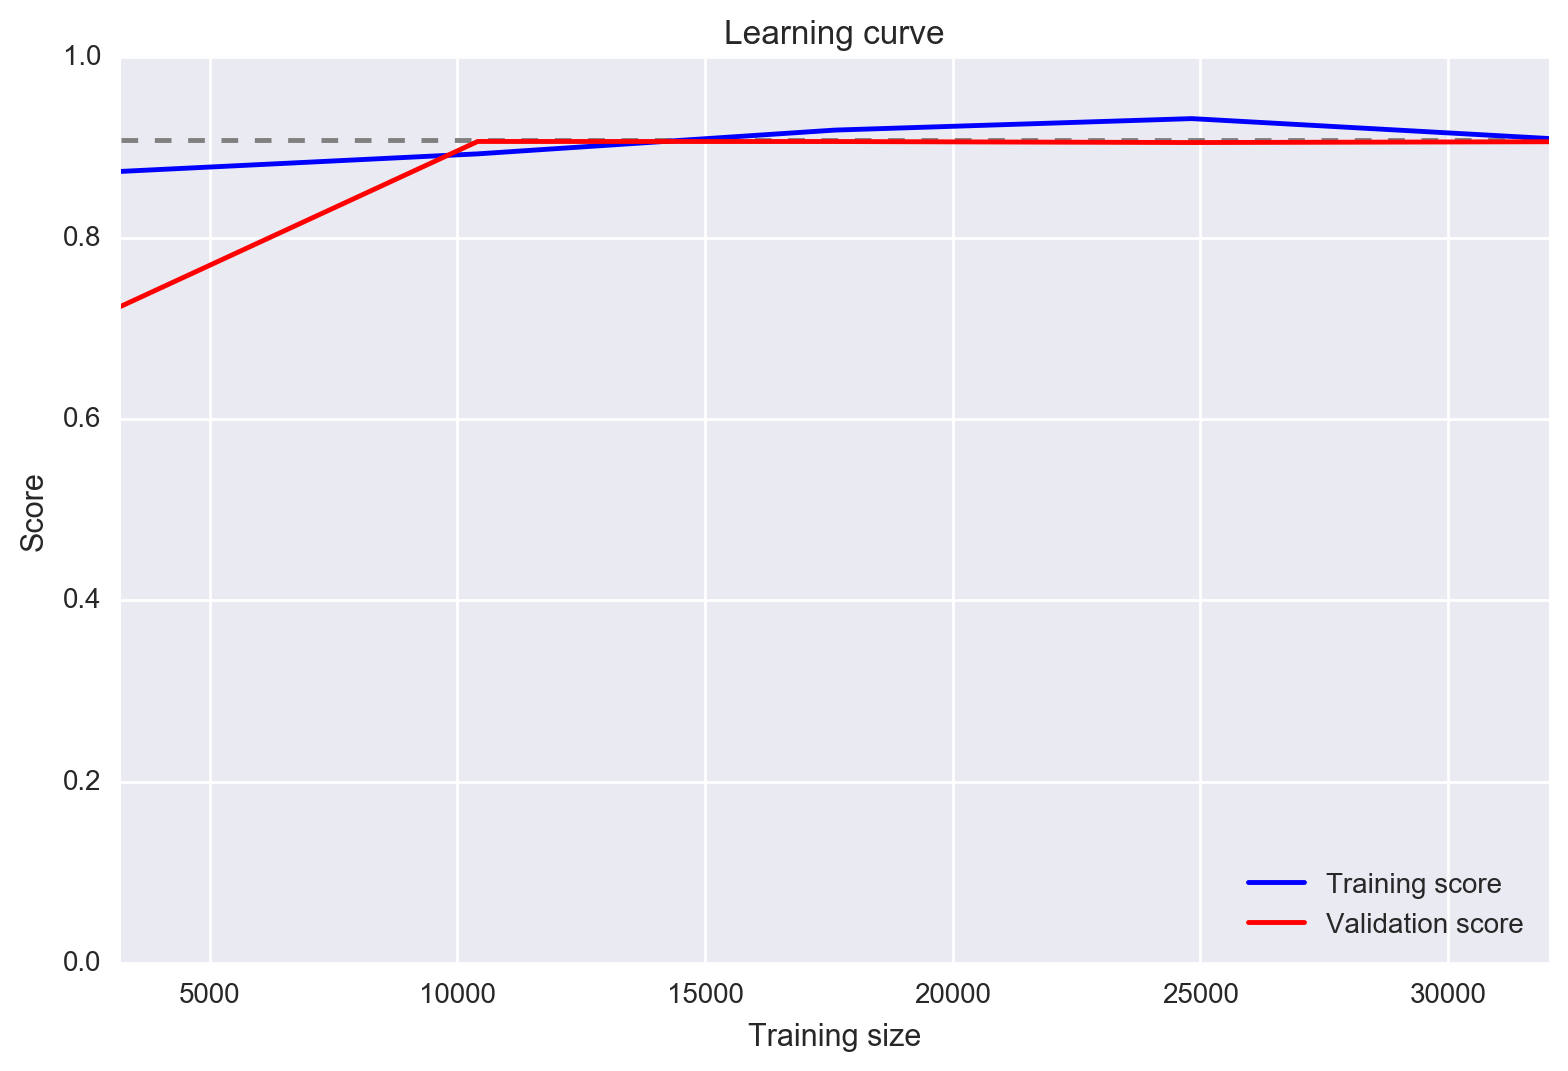

In [22]:
# Learning curve.
fig, ax = plt.subplots(1, 1)

N, train_lc, val_lc = learning_curve(model, X, y, cv=2, train_sizes=np.linspace(0.1, 1.0, 5))

ax.plot(N, np.mean(train_lc, 1), color='blue', label='Training score')
ax.plot(N, np.mean(val_lc, 1), color='red', label='Validation score')
ax.hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray', linestyle='dashed')

ax.set_ylim(0, 1)
ax.set_xlim(N[0], N[-1])
ax.set_xlabel('Training size')
ax.set_ylabel('Score')
ax.set_title('Learning curve')
ax.legend(loc='lower right')

plt.tight_layout()